## Transformer Training
This notebook sets up a basic Transformer model for use in this project.

In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 10.7 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import optuna

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Toy Problem
Setting up a toy time series binary classification problem. Generating a dataloader that contains univariate time series that is either linear or log.

In [ ]:
def generate_data(length, batch):
    X_data = []
    y_data = []
    
    for i in range(5000):
        eps = np.random.rand(3)
        X_data.append(np.linspace(0+(eps[0]/10), 1+(eps[1]/10), length) * eps[2])
        y_data.append(1)
    
    for i in range(5000):
        eps = np.random.rand(3)
        X_data.append(np.geomspace(0.0000001+(eps[0]/10), 1+(eps[1]/10), length) * eps[2])
        y_data.append(0)
    
    tensor_x = torch.Tensor(X_data).to(device)
    tensor_y = torch.Tensor(y_data).to(device)
    
    return DataLoader(TensorDataset(tensor_x, tensor_y), batch_size=batch, shuffle=True)

In [ ]:
trainloader = generate_data(512, 64)
example = next(iter(trainloader))

<ipython-input-5-822135b653bf>:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  tensor_x = torch.Tensor(X_data).to(device)


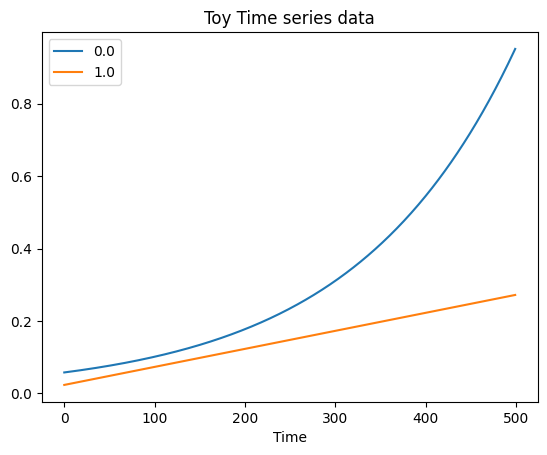

In [ ]:
plt.title("Toy Time series data")
plt.plot(example[0][3].cpu(), label=example[1][3].item())
plt.plot(example[0][0].cpu(), label=example[1][0].item())
plt.xlabel("Time")
plt.legend()

### Hyperparameter Config

In [ ]:
config = {
    'length': 500,
    'hidden_dim': 64,
    'nhead': 5,
    'attn_layers': 6,
    'batch': 64,
    'n_epochs': 100,
    'lr': 1e-5
}

### Transformer Model Architecture

In [ ]:
class Transformer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.length = config['length']
        self.positional_embed = nn.Parameter(torch.randn(self.length))
        
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=self.length, nhead=config['nhead'])
        self.transformer_blocks = nn.TransformerEncoder(self.encoder_layer, num_layers=config['attn_layers'])
        self.classification_head = nn.Linear(self.length, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = x + self.positional_embed
        z = self.transformer_blocks(x)
        z = self.classification_head(z)
        return self.sigmoid(z.squeeze(1))

### Training Loop

In [ ]:
objective = nn.BCELoss()

tran = Transformer(config).to(device)

lr = 1e-5
n_epochs = 10
optim = torch.optim.Adam(tran.parameters(), lr=lr)
losses = []

for n in range(n_epochs):
    counter = 0
    for i, (X, y) in enumerate(tqdm(trainloader)):
        optim.zero_grad()
        yhat = tran(X)
        loss = objective(yhat, y)
        loss.backward()
        losses.append(loss.item())
        optim.step()
        counter += 1
        
    print("Epoch:", n+1, "Loss:",np.mean(losses[-counter:][0]))

100%|██████████| 157/157 [00:13<00:00, 11.94it/s]


Epoch: 1 Loss: 0.7163480520248413


100%|██████████| 157/157 [00:11<00:00, 14.10it/s]


Epoch: 2 Loss: 0.7153804898262024


100%|██████████| 157/157 [00:08<00:00, 18.89it/s]


Epoch: 3 Loss: 0.637732982635498


100%|██████████| 157/157 [00:08<00:00, 17.44it/s]


Epoch: 4 Loss: 0.17315582931041718


100%|██████████| 157/157 [00:08<00:00, 17.46it/s]


Epoch: 5 Loss: 0.15979012846946716


100%|██████████| 157/157 [00:08<00:00, 18.15it/s]


Epoch: 6 Loss: 0.09064722806215286


100%|██████████| 157/157 [00:08<00:00, 17.87it/s]


Epoch: 7 Loss: 0.041866011917591095


100%|██████████| 157/157 [00:09<00:00, 16.85it/s]


Epoch: 8 Loss: 0.02681756764650345


100%|██████████| 157/157 [00:09<00:00, 15.88it/s]


Epoch: 9 Loss: 0.0663861632347107


100%|██████████| 157/157 [00:08<00:00, 18.79it/s]

Epoch: 10 Loss: 0.10080934315919876


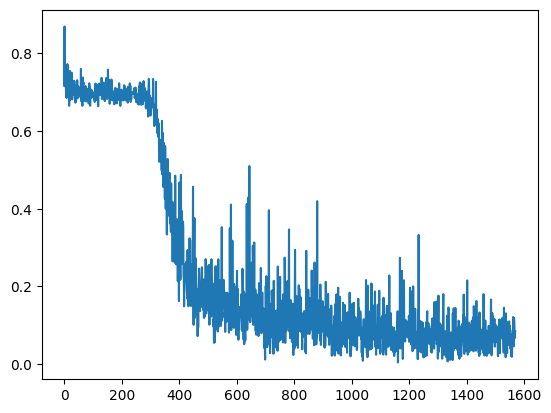

In [ ]:
plt.plot(losses)

### Evaluate Training Accuracy

In [ ]:
with torch.no_grad():
    correct = 0
    N = 0
    
    for i, (X, y) in enumerate(tqdm(trainloader)):
        probs = tran(X)
        preds = torch.round(probs)
        
        correct += (preds == y).sum().item()
        N += y.shape[0]
        
    print("Train Accuracy: ", correct/N)

100%|██████████| 157/157 [00:03<00:00, 48.65it/s]

Train Accuracy:  0.9529


In [ ]:
def objective(trial):
    hyperparams = {
        'length': 512,
        'hidden_dim': trial.suggest_categorical('hidden_dim', [64, 256, 512, 1024]),
        'nhead': trial.suggest_categorical('nhead', [4, 8]),
        'attn_layers': trial.suggest_categorical('attn_layers', [2, 4, 6]),
        'batch':  trial.suggest_categorical('batch', [64, 128, 256, 512]),
        'n_epochs':  trial.suggest_int('n_epochs', [5, 100]),
        'lr': trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    }

    trainloader = generate_data(hyperparams['length'], hyperparams['batch'])
    objective = nn.BCELoss()

    tran = Transformer(hyperparams).to(device)
    optim = torch.optim.Adam(tran.parameters(), lr=hyperparams['lr'])
    losses = []

    for n in range(hyperparams['n_epochs']):
        counter = 0
        for i, (X, y) in enumerate(tqdm(trainloader)):
            optim.zero_grad()
            yhat = tran(X)
            loss = objective(yhat, y)
            loss.backward()
            losses.append(loss.item())
            optim.step()
            counter += 1

        if n+1 % 5 == 0 or n+1 == hyperparams['n_epochs']:
            with torch.no_grad():
                correct = 0
                N = 0
                
                for i, (X, y) in enumerate(tqdm(trainloader)): # change to validation loader
                    probs = tran(X)
                    preds = torch.round(probs)
                    
                    correct += (preds == y).sum().item()
                    N += y.shape[0]
                    
                accuracy = correct/N
                trial.report(accuracy, n)

                if trial.should_prune():
                    raise optuna.TrialPruned()

    return accuracy

In [ ]:
study = optuna.create_study(pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=100)

[I 2023-04-04 18:56:31,330] A new study created in memory with name: no-name-91bce55a-b583-43e6-b848-f1fdf9821d4b
100%|██████████| 157/157 [00:00<00:00, 161.83it/s]
[I 2023-04-04 18:58:47,674] Trial 0 finished with value: 0.4999 and parameters: {'hidden_dim': 1024, 'nhead': 8, 'attn_layers': 6, 'batch': 64, 'n_epochs': 50, 'lr': 0.0034555987744336594}. Best is trial 0 with value: 0.4999.
 78%|███████▊  | 31/40 [00:00<00:00, 39.73it/s]
[W 2023-04-04 18:58:57,182] Trial 1 failed with parameters: {'hidden_dim': 512, 'nhead': 8, 'attn_layers': 6, 'batch': 256, 'n_epochs': 50, 'lr': 0.000683079015419914} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-17-f033994821c6>", line 25, in objective
    loss.backward()
  File "/usr/local/lib/python3.9/dist-packages/torch/_tensor.py", line 487, in backward


KeyboardInterrupt: ignored